# NBA challenge: can we predict the next MVP for 2021 based on past data ?

## Problem definition

The NBA Most Valuable Player (MVP) trophy is an award given each year by the National Basketball Association (NBA) to the best player of the regular season.

To rank a player, we use the share. The higher the share is, the lower his rank will be. The share is computed as follows:


player MVP Share for Year X = MVP votes player receives in Year X / Most MVP votes received by any player in Year X


The goal of this project is to predict this ranking from data collected on players and their teams during the regular season.

## Proposed solution

In order to predict the MVP for the season, we proceed as follows: 

1. Data importation and cleaning 
2. Data exploration to find out relationships between variables 
3. Train a Random forest to predict the share
4. Performances analysis


## Import required modules

In [64]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import GroupKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix

## Data importation and preparation

### Import the data

In [17]:
train_df = pd.read_csv('./data/train.csv')
train_df.describe()

test_df = pd.read_csv('./data/test_2021.csv')
test_df.describe()

,age,g,gs,mp,fg,fga,fg%,3p,3pa,3p%,...,pf,pts,year,w,l,w/l%,gb,ps/g,pa/g,srs
count,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000,539.000000,540.000000,540.00000,521.000000,...,540.000000,540.000000,540.0,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000,540.000000
mean,25.555556,42.692593,20.000000,19.820926,3.287963,7.162593,0.447703,1.002593,2.81500,0.312875,...,1.635185,8.942407,2021.0,35.681481,36.318519,0.495628,11.075926,111.996481,112.193148,-0.181333
std,4.108305,20.706670,23.176183,9.308218,2.345228,4.830470,0.106992,0.904920,2.27559,0.126006,...,0.759005,6.483883,0.0,10.105677,10.105677,0.140304,9.593973,4.215182,3.364704,4.836268
min,19.000000,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,2021.0,17.000000,20.000000,0.236000,0.000000,103.800000,104.700000,-10.130000
25%,22.000000,26.750000,1.000000,12.575000,1.575000,3.600000,0.403000,0.300000,0.97500,0.271000,...,1.100000,4.100000,2021.0,27.000000,30.000000,0.375000,1.000000,109.325000,110.100000,-3.450000
50%,25.000000,46.000000,8.000000,19.600000,2.800000,6.050000,0.442000,0.800000,2.30000,0.341000,...,1.600000,7.350000,2021.0,36.000000,36.000000,0.500000,9.000000,112.950000,112.300000,-0.060000
75%,28.000000,61.000000,38.000000,27.700000,4.600000,9.825000,0.496500,1.600000,4.32500,0.389000,...,2.100000,12.400000,2021.0,42.000000,45.000000,0.583000,20.000000,115.100000,114.300000,2.770000
max,40.000000,72.000000,72.000000,37.600000,11.200000,23.000000,1.000000,5.300000,12.70000,1.000000,...,4.000000,32.000000,2021.0,52.000000,55.000000,0.722000,30.000000,120.100000,118.500000,8.970000


### Checking for missing data

In [18]:
train_df.isnull().sum()
test_df.isnull().sum()

player     0
pos        0
age        0
tm         0
g          0
gs         0
mp         0
fg         0
fga        0
fg%        1
3p         0
3pa        0
3p%       19
2p         0
2pa        0
2p%        5
efg%       1
ft         0
fta        0
ft%       18
orb        0
drb        0
trb        0
ast        0
stl        0
blk        0
tov        0
pf         0
pts        0
year       0
team       0
w          0
l          0
w/l%       0
gb         0
ps/g       0
pa/g       0
srs        0
dtype: int64

After a closer inspection of the two dataframes, missing values are only present in variables representing ratios (when one of the values of the ratio is equal to 0). We can therefore fill the missing data with 0.

In [19]:
# For train
train_df.fillna(0, inplace=True)
# For test
test_df.fillna(0, inplace=True)

# Checking for missing values once again: 
print(train_df.isnull().sum().sum())
print(test_df.isnull().sum().sum())

0
0


### Find the MVP for each year

In [20]:
# Create MVP column
train_df['MVP'] = 0
# Find the player with highest share value for each year
train_df.loc[train_df.groupby('year')['share'].idxmax(), 'MVP'] = 1

# Categorical variables
train_df['MVP'] = train_df['MVP'].astype('category')
train_df['tm'] = train_df['tm'].astype('category')
train_df['year'] = train_df['year'].astype('category')
train_df['pos'] = train_df['pos'].astype('category')
train_df['team'] = train_df['team'].astype('category')

## Exploratory data analysis

First let's find what are the relationships between variables and which ones are correlated with share value

<AxesSubplot:>

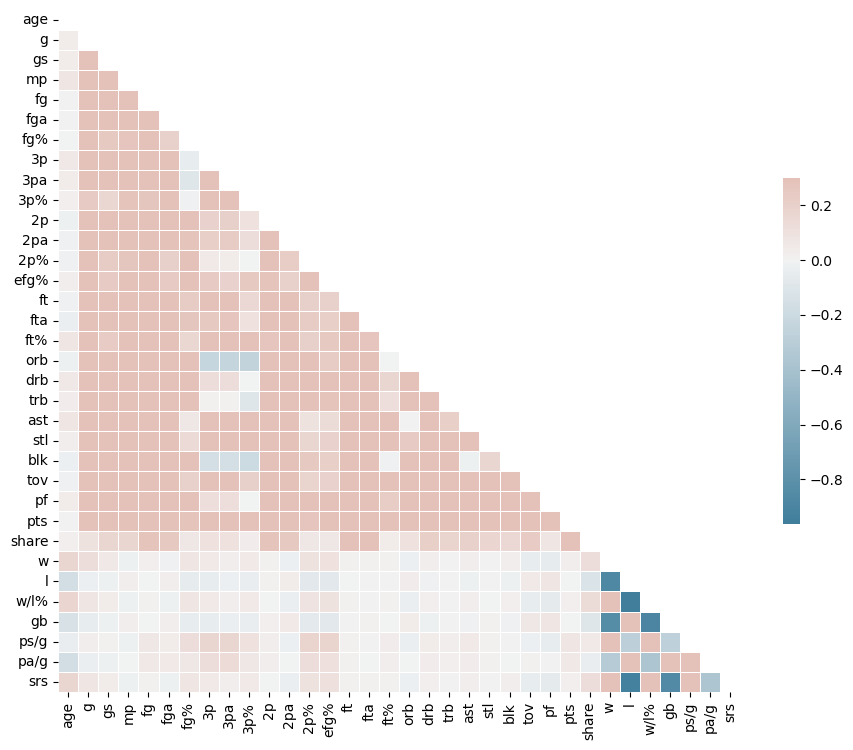

In [21]:
corr_matrix = train_df.select_dtypes(['number']).corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [22]:
corr_matrix['share']

age      0.017869
g        0.089288
gs       0.167539
mp       0.163263
fg       0.277891
fga      0.251100
fg%      0.064830
3p       0.097930
3pa      0.098576
3p%      0.030422
2p       0.276695
2pa      0.252785
2p%      0.063241
efg%     0.059057
ft       0.316600
fta      0.322358
ft%      0.039576
orb      0.100424
drb      0.212943
trb      0.185311
ast      0.200166
stl      0.176384
blk      0.156967
tov      0.233626
pf       0.070109
pts      0.289942
share    1.000000
w        0.123748
l       -0.123233
w/l%     0.127763
gb      -0.102557
ps/g     0.048713
pa/g    -0.041029
srs      0.124389
Name: share, dtype: float64

From the correlation matrix, we can see that some player characteristics are more correlated to the share values than others. It is worth noting that correlation coefficients are quite (max 0.32).

## Predict the share with random forest
### Hyperparameter tuning with grouped Kfold cross validation

In [23]:
target = 'share'
groups = np.array(train_df['year'])
y = np.array(train_df[target])
X = train_df.drop(columns=[target, 'MVP' ,'player', 'year', 'team', 'pos', 'tm']) #do not account categorical var

In [24]:
gkf_cv = GroupKFold(n_splits=5)
gkf_cv.get_n_splits(X, y, groups)

for split, (ix_train, ix_test) in enumerate(gkf_cv.split(X, groups=groups)):
    print(f"SPLIT {split+1}")
    print(f"TRAIN INDEXES: {ix_train}, TEST INDEXES: {ix_test}\n")

SPLIT 1
TRAIN INDEXES: [    0     1     2 ... 13549 13550 13551], TEST INDEXES: [   12    13    14 ... 13498 13499 13500]

SPLIT 2
TRAIN INDEXES: [    0     1     2 ... 13549 13550 13551], TEST INDEXES: [   27    28    29 ... 13444 13445 13446]

SPLIT 3
TRAIN INDEXES: [   12    13    14 ... 13549 13550 13551], TEST INDEXES: [    0     1     2 ... 13532 13533 13534]

SPLIT 4
TRAIN INDEXES: [    0     1     2 ... 13549 13550 13551], TEST INDEXES: [   40    41    42 ... 13517 13518 13519]

SPLIT 5
TRAIN INDEXES: [    0     1     2 ... 13532 13533 13534], TEST INDEXES: [   55    56    57 ... 13549 13550 13551]



In [27]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ndcg_score, make_scorer

rf = RandomForestRegressor(random_state = 42)

param_grid = {
    'max_features': [10, 20],
    'n_estimators': [100, 200]
}

rf_grid = GridSearchCV(estimator=rf, param_grid=param_grid,
                               cv=gkf_cv, verbose=2, n_jobs=-1)

In [28]:
# Fit the grid search model
rf_grid.fit(X, y, groups=groups)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END ..................max_features=10, n_estimators=100; total time=   5.4s
[CV] END ..................max_features=10, n_estimators=100; total time=   5.7s
[CV] END ..................max_features=10, n_estimators=100; total time=   6.0s
[CV] END ..................max_features=10, n_estimators=100; total time=   6.2s
[CV] END ..................max_features=10, n_estimators=100; total time=   6.5s
[CV] END ..................max_features=10, n_estimators=200; total time=  12.3s
[CV] END ..................max_features=10, n_estimators=200; total time=  12.3s
[CV] END ..................max_features=10, n_estimators=200; total time=  12.7s
[CV] END ..................max_features=10, n_estimators=200; total time=  12.8s
[CV] END ..................max_features=10, n_estimators=200; total time=  12.9s
[CV] END ..................max_features=20, n_estimators=100; total time=  13.4s
[CV] END ..................max_features=20, n_est

GridSearchCV(cv=GroupKFold(n_splits=5),
             estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_features': [10, 20], 'n_estimators': [100, 200]},
             verbose=2)

In [65]:
best_grid = rf_grid.best_estimator_

# Saving the model
filename = 'best_rf_model.pkl'
pickle.dump(best_grid, open(filename, 'wb'))

## Evaluating the model
### Evaluating the ranking performance

In [79]:
y_pred = best_grid.predict(X)
# Evaluate random forest on the train set: 
train_df['pred_share'] = y_pred

def compute_ndcg(true_share, pred_share):
    score = ndcg_score([np.asarray(true_share)], [np.asarray(pred_share)], k=3, ignore_ties=True)
    return(score)

res=[]
for grp in np.unique(groups):
    temp_df = train_df[train_df['year'] == grp]
    res.append(compute_ndcg(temp_df['share'], temp_df['pred_share']))
print(np.mean(res))

0.9925951943047769


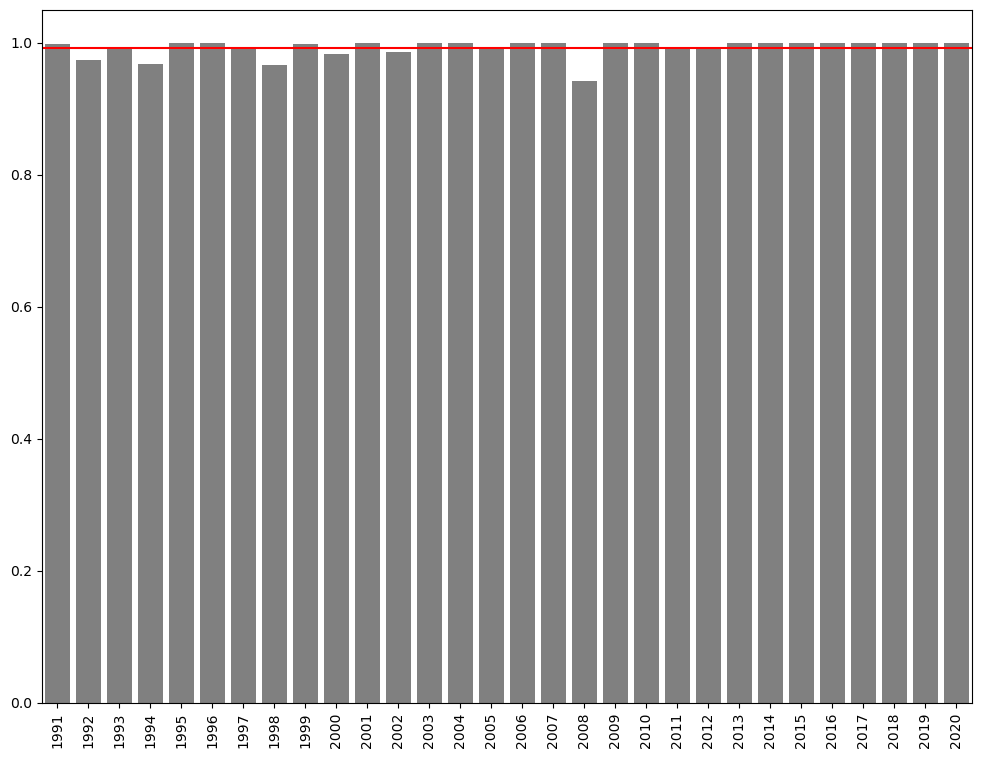

In [78]:
f, ax = plt.subplots(figsize=(12, 9))
g = sns.barplot(x=np.unique(groups) , y= res, color='grey')
g.axhline(np.mean(res), color='red')
ax.tick_params(axis='x', rotation=90)
plt.show()

### Evaluating MVP prediction performance

In [85]:
# Create MVP column
train_df['pred_MVP'] = 0
# Find the player with highest share value for each year
train_df.loc[train_df.groupby('year')['pred_share'].idxmax(), 'pred_MVP'] = 1

confusion_matrix(train_df['MVP'], train_df['pred_MVP'])


(0.9333333333333333, 0.9333333333333333, 0.9333333333333333, None)